In [1]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# read the data
df = pd.read_csv('full_data.csv')
df.head()

,Unnamed: 0,id,Song title,Artist,Current Ranking,Number of weeks on billboard,Peak Ranking,Date,Danceability,Energy,...,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration ms,Time Signature,Song Score
0,0,1,All I Want For Christmas Is You,Mariah Carey,1,17,1,2022-01-01,0.626,0.357,...,0.0,0.0631,0.354,0.000000,0.0552,0.401,179.869,238867.0,3.0,79.0
1,1,2,Last Christmas,Wham!,2,15,2,2022-01-01,0.735,0.478,...,1.0,0.0293,0.189,0.000002,0.3550,0.947,107.682,262960.0,4.0,3.0
2,2,3,Rockin' Around The Christmas Tree,Brenda Lee,3,13,3,2022-01-01,0.589,0.472,...,1.0,0.0502,0.614,0.000000,0.5050,0.898,67.196,126267.0,4.0,60.0
3,3,4,Jingle Bell Rock,Bobby Helms,4,13,4,2022-01-01,0.754,0.424,...,1.0,0.0363,0.643,0.000000,0.0652,0.806,119.705,130973.0,4.0,53.0
4,4,5,abcdefu,GAYLE,5,6,2,2022-01-01,0.695,0.540,...,1.0,0.0493,0.299,0.000000,0.3670,0.415,121.932,168602.0,4.0,70.0


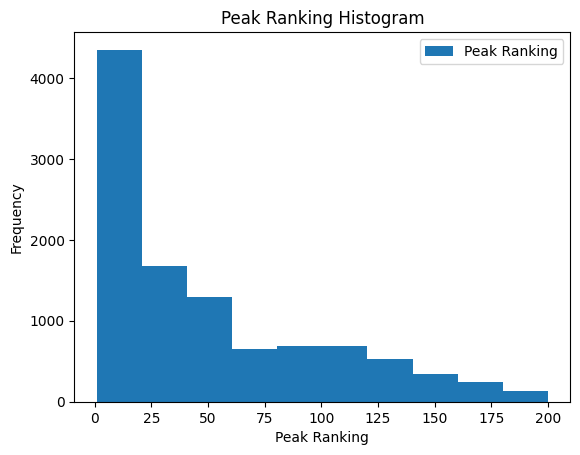

C:\Users\shayer\AppData\Local\Temp\ipykernel_24980\49360494.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,Unnamed: 0,id,Current Ranking,Number of weeks on billboard,Peak Ranking,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration ms,Time Signature,Song Score
Unnamed: 0,1.000000,1.000000,0.018868,0.058626,-0.076726,-0.050373,-0.002711,-0.032851,-0.007775,-0.009942,-0.020630,0.025414,0.018303,0.027838,-0.089381,-0.048038,0.018376,-0.083469,0.040228
id,1.000000,1.000000,0.018868,0.058626,-0.076726,-0.050373,-0.002711,-0.032851,-0.007775,-0.009942,-0.020630,0.025414,0.018303,0.027838,-0.089381,-0.048038,0.018376,-0.083469,0.040228
Current Ranking,0.018868,0.018868,1.000000,0.127934,0.586478,-0.052942,0.014596,-0.028576,-0.052367,0.105965,-0.004343,-0.034304,0.041610,0.030420,0.035534,0.007556,0.071194,0.016855,-0.072065
Number of weeks on billboard,0.058626,0.058626,0.127934,1.000000,-0.165242,-0.037027,0.019071,0.041121,0.038722,0.049799,-0.125730,0.042505,-0.027050,-0.073055,0.109250,-0.016636,0.080235,0.129208,0.140243
Peak Ranking,-0.076726,-0.076726,0.586478,-0.165242,1.000000,-0.094022,0.043258,-0.049536,-0.061189,0.169905,-0.085100,-0.019483,0.070746,0.041611,0.024985,-0.021674,0.094305,-0.012742,-0.204143
Danceability,-0.050373,-0.050373,-0.052942,-0.037027,-0.094022,1.000000,0.262625,0.094292,0.321941,-0.109447,0.229932,-0.312137,-0.182781,-0.176324,0.459795,-0.125474,-0.258666,0.231652,0.027934
Energy,-0.002711,-0.002711,0.014596,0.019071,0.043258,0.262625,1.000000,0.068927,0.752378,0.039340,0.034660,-0.632970,-0.211175,0.002433,0.345685,0.111677,-0.048144,0.225865,0.059093
Key,-0.032851,-0.032851,-0.028576,0.041121,-0.049536,0.094292,0.068927,1.000000,0.011830,-0.222490,0.010800,-0.041244,-0.005725,-0.068657,0.117434,0.116674,-0.059576,0.008474,-0.025948
Loudness,-0.007775,-0.007775,-0.052367,0.038722,-0.061189,0.321941,0.752378,0.011830,1.000000,0.010748,0.026399,-0.444929,-0.336567,-0.031728,0.282675,-0.068269,-0.082485,0.135211,0.158495
Mode,-0.009942,-0.009942,0.105965,0.049799,0.169905,-0.109447,0.039340,-0.222490,0.010748,1.000000,-0.139962,0.077626,0.085259,-0.105903,0.110169,-0.016247,0.006955,-0.044060,-0.191887


In [3]:
peak = df.plot.hist(y='Peak Ranking')

# Set the title and labels of the plot
peak.set_title('Peak Ranking Histogram')
peak.set_xlabel('Peak Ranking')
peak.set_ylabel('Frequency')

# Show the peak ranking histogram
plt.show()

# From the histogram shown, we need to perfom binning

# Plot Correlation Matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [16]:
variable_list = [
        'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 
        'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo', 'Duration ms', 'Time Signature','Song Score']

removed_variables = ['Number of weeks on billboard','Artist','Song Title','Current Ranking',]


X = df[variable_list]
y = df['Peak Ranking']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109)

In [17]:
# Encode categorical features
#import label encoder
from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# cols = ['Artist', 'Song title']
# X_train[cols] = X_train[cols].apply(le.fit_transform)
# X_test[cols] = X_test[cols].apply(le.fit_transform)

# Scale continuous features
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

X_train[variable_list] = scaler.fit_transform(X_train[variable_list])

X_test[variable_list] = scaler.fit_transform(X_test[variable_list])

#create 8 equal bins for y_test & y_train
bin_y_train = pd.cut(y_train, bins=8, labels=False)
# print(bin_y_train.value_counts())

bin_y_test = pd.cut(y_test, bins=8, labels=False)
# print(bin_y_test.value_counts())

binner = [0,20,200]

bin_y_train_2 = pd.cut(y_train, bins=binner, labels=False)

bin_y_test_2 = pd.cut(y_test, bins=binner, labels=False)

print(bin_y_test_2.value_counts())



1    1838
0    1342
Name: Peak Ranking, dtype: int64


In [32]:
#Logistic Regression

# define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100]}

# perform a grid search over the parameter grid using cross-validation
lr_cv = GridSearchCV(LogisticRegression(random_state=109, multi_class='ovr'), param_grid, cv=5, scoring = 'f1_macro')
lr_cv.fit(X_train, bin_y_train_2)

# use the best hyperparameters to fit the model and make predictions on the test set
best_lr = lr_cv.best_estimator_
y_pred_lr = best_lr.predict(X_test)

# evaluate the performance of the model on the test set
print('Binary Logistic Regression Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_lr, average = 'weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_lr, average = 'weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_lr, average = 'weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_lr))

Binary Logistic Regression Scores:
F1 Score: 0.5954134033810357
Precision: 0.6173409668345918
Recall: 0.6235849056603774
Accuracy: 0.6235849056603774


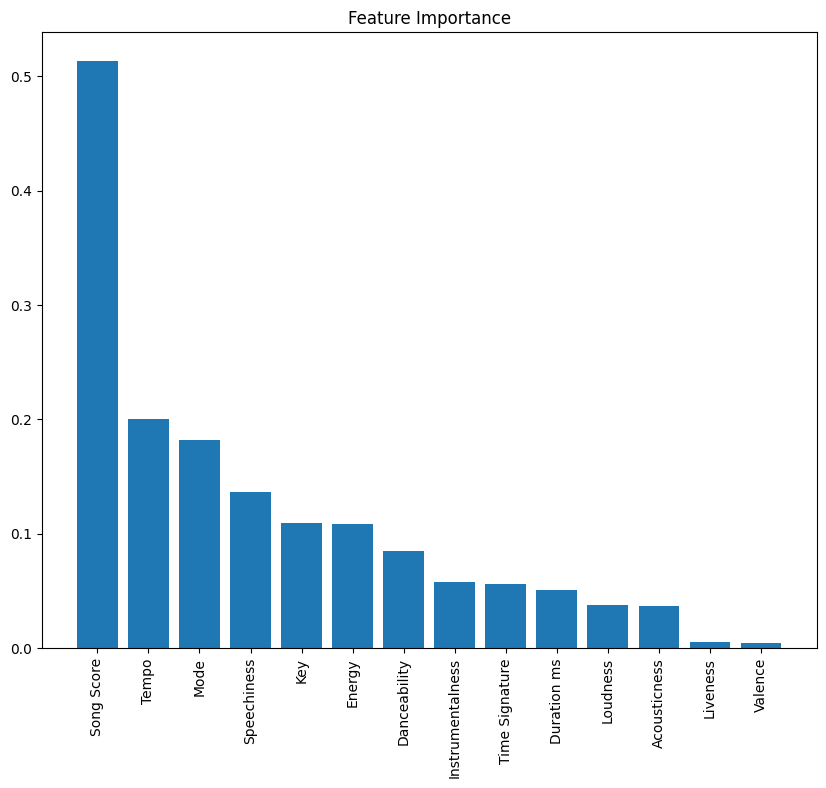

In [19]:
# Get absolute coefficients of the logistic classifier
coef = abs(best_lr.coef_[0])

# Sort feature importance scores in descending order
indices = coef.argsort()[::-1]

# Create feature importance plot
plt.figure(figsize=(10,8))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), coef[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

In [33]:
#Support Vector Machines

# Use GridSearchCV to find the best hyperparameters for SVM
svm = SVC(random_state=109)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'decision_function_shape': ['ovr', 'ovo']}
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
svm = grid_search.best_estimator_

# reduce the number of features using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Use feature selection to select the most important features
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train, bin_y_train_2)
X_train = selector.transform(X_train)
X_val = selector.transform(X_test)

# Train the SVM model on the selected features
svm.fit(X_train, bin_y_train_2)
y_pred_svm = svm.predict(X_test)

# Evaluate the performance of the SVM model
print('Binary Support Vector Machine Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_svm, average = 'weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_svm, average = 'weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_svm, average = 'weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_svm))

Binary Support Vector Machine Scores:
F1 Score: 0.8429929632537926
Precision: 0.842924687833391
Recall: 0.8430817610062893
Accuracy: 0.8430817610062893


In [34]:
#Adaboost

# Initialize the AdaBoost model
ada = AdaBoostClassifier(random_state=109)

# Define the hyperparameters to search over using GridSearchCV
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 500, 1000]}

# Use GridSearchCV to find the best hyperparameters for the model
grid_search = GridSearchCV(ada, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
ada = grid_search.best_estimator_

# Train the AdaBoost model on the selected features
ada.fit(X_train, bin_y_train_2)
y_pred_ada = ada.predict(X_test)

# Evaluate the performance of the AdaBoost model
print('Binary AdaBoost Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_ada, average='weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_ada, average='weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_ada, average='weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_ada))

Binary AdaBoost Scores:
F1 Score: 0.7458738247521587
Precision: 0.7558655217894354
Recall: 0.7528301886792453
Accuracy: 0.7528301886792453


In [35]:
#Gradient Boosting

# Initialize the Gradient Boosting model
gboost = GradientBoostingClassifier(random_state = 109)

# Define the hyperparameters to search over using GridSearchCV
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 7]}

# Use GridSearchCV to find the best hyperparameters for the model
grid_search = GridSearchCV(gboost, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
gboost = grid_search.best_estimator_

# Train the Gradient Boosting model on the selected features
gboost.fit(X_train, bin_y_train_2)
y_pred_gboost = gboost.predict(X_test)

# Evaluate the performance of the Gradient Boosting model
print('Binary Gradient Boosting Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_gboost, average='weighted'))
print('Precision:', precision_score(bin_y_test_2, y_pred_gboost, average='weighted'))
print('Recall:', recall_score(bin_y_test_2, y_pred_gboost, average='weighted'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_gboost))

Binary Gradient Boosting Scores:
F1 Score: 0.7995215952779191
Precision: 0.8100423429723905
Recall: 0.8044025157232705
Accuracy: 0.8044025157232705


### Summary table to show the performance of the models

#precision to 3sf 

Model| F1 Score | Precision | Recall | Accuracy |
---|---|---|---|---|
Binary Logistic Regression | 0.593 | 0.613 | 0.620 | 0.620 | 
Binary Support Vector Machine | 0.843 | 0.843 | 0.843 | 0.843 | 
Binary Adaboost | 0.746 | 0.756 | 0.753 | 0.753 | 
Binary Gradient Boosting | 0.800 | 0.810 | 0.804 | 0.804 |

In [ ]:
# Make predictions on the test set using the best model (Gradient Boosting)
test_preds = pd.DataFrame(y_pred_gboost)

In [ ]:
# Save the predictions to a csv file
test_preds.to_csv('Charted_predict.csv', header = ['y'], index_label = 'Index')